In [1]:
"""
file은 크게 Data Preparation, Base Model, Add No Finding으로 나뉘어있음
DataPreparation은 package import, 나눈 데이터들과 csv를 drive에서 불러오는 과정
Base Model은 중권님이 보내줬던 것 그대로 실행
Add No Finding은 여러가지 실험했던 것들
    - 실험 한 결과는 csv와 weight로 저장함 (초반 실험은 기록이 안되어있음..)
    - 실험 내용
        - ForcedBCE어쩌구Loss부분에서 여러가지를 추가하고 빼보면서 결과 기록
        - 1 그냥 BCEwithLogitLoss 사용
        - 2 MSELoss 사용 -> 쓸데없음
        - 3 allzero penalty 추가 (전부 0이 되지는 않게 함) -> 결과 애매 (하지만 논리상 필요)
        - 4 nofinding penalty 추가 (nofinding이 1이면 나머지 0이 되게 함) -> 결과 애매 (하지만 논리상 필요)
        - 5 focal weight 추가 (imbalanced 상황에서 BCE보완) -> 결과 괜찮게 나옴
        - 5.1 focal weight에서 alpha, gamma term이 있는데 이걸 바꿔봄 -> 결과 애매
        - 6 class weight 추가 (imbalanced 상황에서 BCE보완) -> 결과 애매
        - 7 initial_alpha, initial_beta를 학습 가능하게 바꿈 -> beta가 음수로 가며 결과 엉망. alpha만 학습시킬 땐 학습안됨. 계속 0.1유지.
    - bestmodel : allzero penalty, nofinding penalty, focal weight를 loss에 추가한 후 epoch 9번 돌린 모델

    - Dataset, Resnet18 define에선 Nofinding을 label로 추가하는 걸 실행
    - DataLoader, Model, Test 안바꿈 (아마도...)
    - Train에선 log 기록하는거 말곤 안바꿈 (아마도...)
Hyperparameter Tuning
    - optuna쓰는건데 최종모델에 대해서 돌리겠습니다.

"""

'\nfile은 크게 Data Preparation, Base Model, Add No Finding으로 나뉘어있음\nDataPreparation은 package import, 나눈 데이터들과 csv를 drive에서 불러오는 과정\nBase Model은 중권님이 보내줬던 것 그대로 실행\nAdd No Finding은 여러가지 실험했던 것들\n    - 실험 한 결과는 csv와 weight로 저장함 (초반 실험은 기록이 안되어있음..)\n    - 실험 내용\n        - ForcedBCE어쩌구Loss부분에서 여러가지를 추가하고 빼보면서 결과 기록\n        - 1 그냥 BCEwithLogitLoss 사용\n        - 2 MSELoss 사용 -> 쓸데없음\n        - 3 allzero penalty 추가 (전부 0이 되지는 않게 함) -> 결과 애매 (하지만 논리상 필요)\n        - 4 nofinding penalty 추가 (nofinding이 1이면 나머지 0이 되게 함) -> 결과 애매 (하지만 논리상 필요)\n        - 5 focal weight 추가 (imbalanced 상황에서 BCE보완) -> 결과 괜찮게 나옴\n        - 5.1 focal weight에서 alpha, gamma term이 있는데 이걸 바꿔봄 -> 결과 애매\n        - 6 class weight 추가 (imbalanced 상황에서 BCE보완) -> 결과 애매\n        - 7 initial_alpha, initial_beta를 학습 가능하게 바꿈 -> beta가 음수로 가며 결과 엉망. alpha만 학습시킬 땐 학습안됨. 계속 0.1유지.\n    - bestmodel : allzero penalty, nofinding penalty, focal weight를 loss에 추가한 후 epoch 9번 돌린 모델\n    \n    - Dataset, Resnet18 define에선 Nofinding을 label로 추가하는 걸 

## Data Preparation

In [3]:
# prompt: drive mount
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torchvision import transforms
from tqdm import tqdm
import torch
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import random
import os
from torchvision import transforms
from PIL import Image
import torch
from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit
import pandas as pd
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score
import time
import os
import zipfile
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score


# from google.colab import drive
# drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms, datasets, models
import urllib.request
import tarfile
import os
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm

import os
import urllib.request
import threading

# 다운로드 받을 경로 설정 (예: 현재 디렉터리 또는 지정된 경로)
download_path = 'DATA'  # 원하는 경로로 변경 가능

# 다운로드 경로가 존재하지 않으면 생성
if not os.path.exists(download_path):
    os.makedirs(download_path)

# 파일 URL 리스트
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]

# 파일 다운로드 함수
def download_file(url, download_dir, idx):
    fn = os.path.join(download_dir, f'images_{idx+1:02d}.tar.gz')
    print(f'Downloading {fn}...')
    urllib.request.urlretrieve(url, fn)  # 파일 다운로드
    print(f'{fn} download complete.')

# 다운로드 스레드 생성
threads = []
for idx, link in enumerate(links):
    thread = threading.Thread(target=download_file, args=(link, download_path, idx))
    threads.append(thread)
    thread.start()

# 모든 스레드가 끝날 때까지 기다리기
for thread in threads:
    thread.join()

print("All downloads complete. Files are saved in", download_path)

import os
import tarfile
import shutil

# tar 파일들이 저장된 경로 (다운로드 경로와 동일하게 설정)
tar_dir = 'DATA'  # 원본 tar 파일들이 저장된 경로
extract_dir = 'DATA'  # 압축 해제할 경로

# Loop through each downloaded tar file and extract it
for idx in range(1, len(links) + 1):
    tar_path = os.path.join(tar_dir, f'images_{idx:02d}.tar.gz')

    # Extract the tar file into the specified directory
    print(f'Extracting {tar_path} to {extract_dir}...')
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

    # Delete the original tar.gz file after extraction
    os.remove(tar_path)
    print(f'Deleted {tar_path} after extraction.')

print("Extraction complete.")



DATA/images_01.tar.gz download complete.
DATA/images_12.tar.gz download complete.
DATA/images_02.tar.gz download complete.
DATA/images_05.tar.gz download complete.
DATA/images_04.tar.gz download complete.
DATA/images_03.tar.gz download complete.
DATA/images_07.tar.gz download complete.
DATA/images_08.tar.gz download complete.
DATA/images_06.tar.gz download complete.
DATA/images_09.tar.gz download complete.
DATA/images_10.tar.gz download complete.
DATA/images_11.tar.gz download complete.
All downloads complete. Files are saved in DATA
Extracting DATA/images_01.tar.gz to DATA...
Deleted DATA/images_01.tar.gz after extraction.
Extracting DATA/images_02.tar.gz to DATA...
Deleted DATA/images_02.tar.gz after extraction.
Extracting DATA/images_03.tar.gz to DATA...
Deleted DATA/images_03.tar.gz after extraction.
Extracting DATA/images_04.tar.gz to DATA...
Deleted DATA/images_04.tar.gz after extraction.
Extracting DATA/images_05.tar.gz to DATA...
Deleted DATA/images_05.tar.gz after extraction.


In [5]:
datapath = "./DATA/images"

## Dataset, Resnet18 define

In [6]:
print(torch.cuda.current_device())

def get_labels(diseases):
    labels = torch.zeros(len(class_names))
    if diseases != 'No Finding':
        for label_name in diseases.split('|'):
            if label_name in class_names:
                labels[class_names.index(label_name)] = 1
    return labels

class CXR14dataset(Dataset):
    def __init__(self, img_dirs, df, augment=None):
        self.img_dirs = img_dirs
        self.df = df
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5123], [0.2307])
        ])
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        diseases = self.df.iloc[idx, 1]
        label = get_labels(diseases)

        image = None
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                break

        if image is None:
            raise FileNotFoundError(f"Image {img_name} not found in provided directories.")

        if self.augment:
            image = self.augment(image)
        else:
            image = self.transform(image)

        return image, label

class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()

        resnet = resnet18(weights="IMAGENET1K_V1")  # Always use pretrained weights
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.4)
        self.dropout3 = nn.Dropout(p=0.4)
        self.dropout4 = nn.Dropout(p=0.5)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout4(x)
        x = self.fc(x)
        return x

0


## DataLoader

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import random
import os
from torchvision import transforms
from PIL import Image
import torch
from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit
import pandas as pd


csv_file_path = './Data_Entry_2017_v2020.csv'

df = pd.read_csv(csv_file_path)


class_names = ['Atelectasis',  'Consolidation',  'Effusion',
                 'Infiltration', 'Mass', 'Nodule', 'Pneumothorax'
                #'Pleural_Thickening',
               #'Hernia',
               # 'Pneumonia',
               # 'Fibrosis',
               #  'Edema',
               # 'Cardiomegaly',
               # 'Emphysema',
            ]

def get_labels(diseases):
    labels = torch.zeros(len(class_names))
    if diseases != 'No Finding':
        for label_name in diseases.split('|'):
            if label_name in class_names:
                labels[class_names.index(label_name)] = 1
    return labels

class CXR14dataset(Dataset):
    def __init__(self, img_dirs, df, augment=None):
        self.img_dirs = img_dirs
        self.df = df
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5123], [0.2307])
        ])
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        diseases = self.df.iloc[idx, 1]
        label = get_labels(diseases)

        image = None
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                break

        if image is None:
            raise FileNotFoundError(f"Image {img_name} not found in provided directories.")

        if self.augment:
            image = self.augment(image)
        else:
            image = self.transform(image)

        return image, label

img_dirs = ['./DATA/images']

# 데이터셋을 train, validation, test로 나누기 (Stratified Split을 사용하여 클래스 비율 유지)
# 모든 질병 컬럼을 하나의 벡터로 결합하여 분할 (멀티 라벨 문제에 대한 처리)
df['combined_labels'] = df['Finding Labels'].apply(
    lambda x: '|'.join(sorted([label for label in x.split('|') if label in class_names]))
)

sampling_ratios = {
    'Atelectasis': 1,
    'Cardiomegaly': 1,
    'Consolidation': 1,
    #'Edema': 1,
    'Effusion': 1,
    'Emphysema': 1,
    #'Fibrosis': 1,
    #'Hernia': 1,
    'Infiltration': 1,
    'Mass': 1,
    'Nodule': 1,
    #'Pneumonia': 1,
    'Pleural_Thickening': 1,
    'Pneumothorax': 1,
    'No Finding': 0.6
}

def apply_class_sampling(df, class_names, sampling_ratios):
    sampled_df = pd.DataFrame()
    for class_name in class_names:
        if class_name == 'No Finding':
            no_finding_df = df[df['Finding Labels'] == 'No Finding']
            sample_size = int(len(no_finding_df) * sampling_ratios[class_name])
            sampled_no_finding_df = no_finding_df.sample(n=sample_size, random_state=42)
            sampled_df = pd.concat([sampled_df, sampled_no_finding_df], axis=0)
        else:
            class_df = df[df['Finding Labels'].str.contains(class_name)]
            sample_size = int(len(class_df) * sampling_ratios[class_name])
            sampled_class_df = class_df.sample(n=sample_size, random_state=42)
            sampled_df = pd.concat([sampled_df, sampled_class_df], axis=0)
    return sampled_df

class_names_nf = class_names + ['No Finding']
print(class_names)

df_sampled = apply_class_sampling(df, class_names, sampling_ratios)

class_counts = df_sampled['combined_labels'].value_counts()

rare_classes = class_counts[class_counts < 10].index

df_filtered = df_sampled[~df_sampled['combined_labels'].isin(rare_classes)]

# train_df, temp_df = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['combined_labels'], random_state=42)
# valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['combined_labels'], random_state=42)


group_split = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_indices, temp_indices = next(group_split.split(df_filtered, groups=df_filtered['Patient ID']))
train_df = df_filtered.iloc[train_indices]
temp_df = df_filtered.iloc[temp_indices]

stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for valid_indices, test_indices in stratified_split.split(temp_df, temp_df['combined_labels']):
    valid_df = temp_df.iloc[valid_indices]
    test_df = temp_df.iloc[test_indices]

print(f"Train data: {train_df.shape}")
print(f"Validation data: {valid_df.shape}")
print(f"Test data: {test_df.shape}")


batch_size = 64
num_cores = os.cpu_count()
train_dataset = CXR14dataset(img_dirs=img_dirs, df=train_df)
valid_dataset = CXR14dataset(img_dirs=img_dirs, df=valid_df)
test_dataset = CXR14dataset(img_dirs=img_dirs, df=test_df)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=True, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True, persistent_workers=True)


for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break


['Atelectasis', 'Consolidation', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumothorax']
Train data: (53388, 12)
Validation data: (6700, 12)
Test data: (6701, 12)
torch.Size([64, 3, 224, 224])
torch.Size([64, 7])


## Model

In [50]:
num_classes = len(class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomResNet18(num_classes=num_classes).to(device)

input_size = (3, 224, 224)
summary(model, input_size=input_size, device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Force at least one class

## Dataset, Resnet18 define

In [51]:
print(torch.cuda.current_device())

# Add No findings
def get_labels(diseases):
    labels = torch.zeros(len(class_names))
    for label_name in diseases.split('|'):
        if label_name in class_names:
            labels[class_names.index(label_name)] = 1
    return labels

class CXR14dataset(Dataset):
    def __init__(self, img_dirs, df, augment=None):
        self.img_dirs = img_dirs
        self.df = df
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.5123], [0.2307])
        ])
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        diseases = self.df.iloc[idx, 1]
        label = get_labels(diseases)

        image = None
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):
                image = Image.open(img_path).convert("RGB")
                break

        if image is None:
            raise FileNotFoundError(f"Image {img_name} not found in provided directories.")

        if self.augment:
            image = self.augment(image)
        else:
            image = self.transform(image)

        return image, label

class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()

        resnet = resnet18(weights="IMAGENET1K_V1")  # Always use pretrained weights
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool

        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.4)
        self.dropout3 = nn.Dropout(p=0.4)
        self.dropout4 = nn.Dropout(p=0.5)

        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = self.dropout3(x)

        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout4(x)
        x = self.fc(x)
        return x

0


## Model

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CustomResNet18(num_classes=num_classes).to(device)

#input_size = (3, 224, 224)
#summary(model, input_size=input_size, device=device.type)

<ipython-input-53-35b5eda21df0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['combined_labels'].fillna("No Finding", inplace=True)
<ipython-input-53-35b5eda21df0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['combined_labels'].fillna("No Finding", inplace=True)
<ipython-input-53-35b5eda21df0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['combined_labels'].fillna("No Finding", inplace=True)


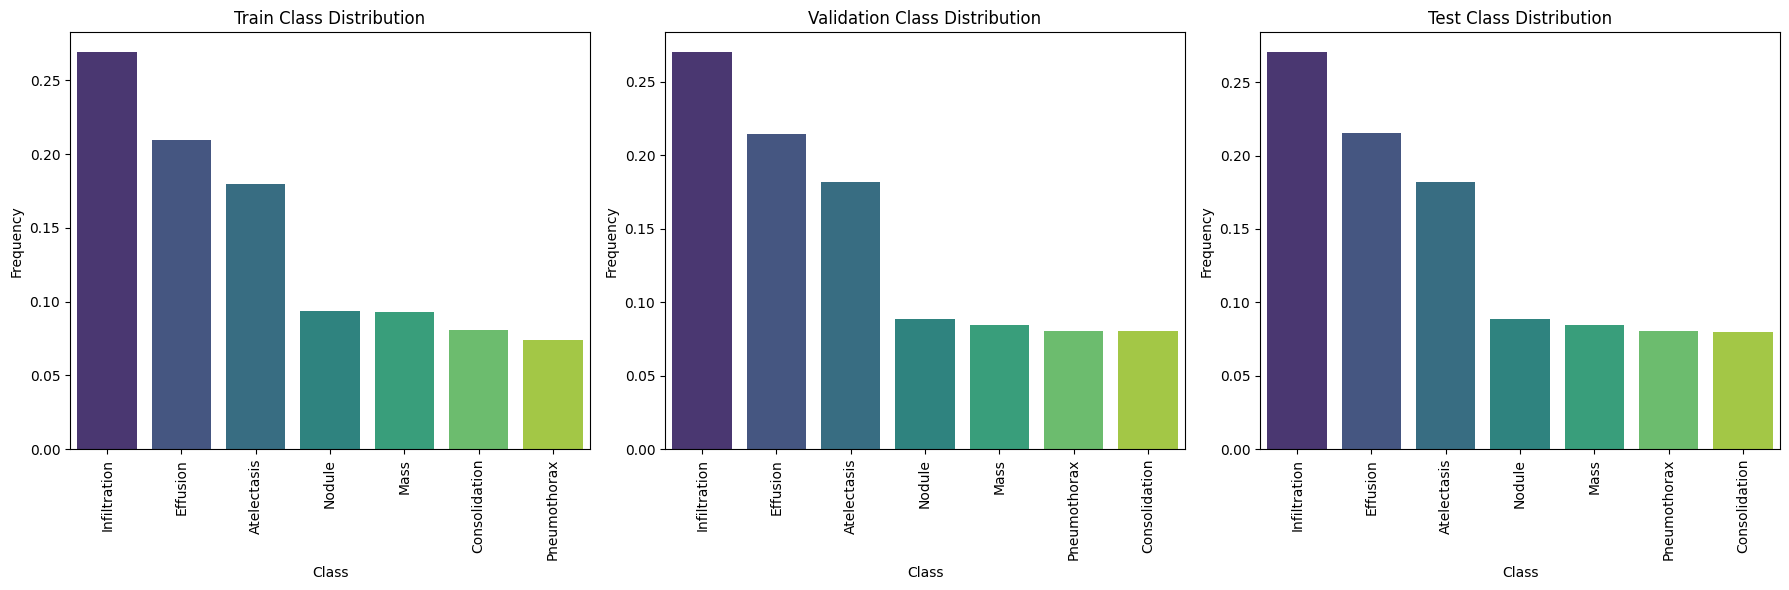

In [53]:
import matplotlib.pyplot as plt

train_df['combined_labels'].fillna("No Finding", inplace=True)
valid_df['combined_labels'].fillna("No Finding", inplace=True)
test_df['combined_labels'].fillna("No Finding", inplace=True)

import seaborn as sns

train_class_counts = train_df['combined_labels'].str.split('|', expand=True).stack().value_counts()
valid_class_counts = valid_df['combined_labels'].str.split('|', expand=True).stack().value_counts()
test_class_counts = test_df['combined_labels'].str.split('|', expand=True).stack().value_counts()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x=train_class_counts.index, y=train_class_counts.values/train_class_counts.sum(), palette='viridis', ax=axes[0])
axes[0].set_title('Train Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(x=valid_class_counts.index, y=valid_class_counts.values/valid_class_counts.sum(), palette='viridis', ax=axes[1])
axes[1].set_title('Validation Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=90)

sns.barplot(x=test_class_counts.index, y=test_class_counts.values/test_class_counts.sum(), palette='viridis', ax=axes[2])
axes[2].set_title('Test Class Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Frequency')
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [54]:
one_over_tcc = train_class_counts.sum() / train_class_counts
one_over_tcc

,count
Infiltration,3.715659
Effusion,4.775730
Atelectasis,5.564464
Nodule,10.675949
Mass,10.769057
Consolidation,12.325642
Pneumothorax,13.494181


In [55]:
one_over_tcc = one_over_tcc / one_over_tcc.mean()
one_over_tcc

,count
Infiltration,0.424157
Effusion,0.545169
Atelectasis,0.635206
Nodule,1.218702
Mass,1.229331
Consolidation,1.407021
Pneumothorax,1.540415


In [56]:
class_weights = [np.round(one_over_tcc.loc[x],2) for x in class_names]
class_weights

[0.64, 1.41, 0.55, 0.42, 1.23, 1.22, 1.54]

In [57]:
class ForcedBCEWithLogitsLoss(nn.Module):
    def __init__(self, reduction='mean', initial_alpha=0.1, initial_beta=0.1, gamma_neg=4, gamma_pos=1, class_weights=class_weights):
        super(ForcedBCEWithLogitsLoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction=reduction, weight= None) #torch.tensor(class_weights))
        self.initial_alpha = initial_alpha
        #self.alpha = nn.Parameter(torch.tensor(initial_alpha, dtype=torch.float32))  # Learnable parameter
        self.initial_beta = initial_beta
        # self.beta = nn.Parameter(torch.tensor(initial_beta, dtype=torch.float32))  # Learnable parameter
        self.mse_loss = nn.MSELoss()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        #self.class_weight = class_weight

    def forward(self, logits, targets):

        ## BCEWithLogitsLoss
        bce_loss = self.bce_loss(logits, targets)


        ## class probabilities
        probs = torch.sigmoid(logits)


        ## MSELoss
        # mse_loss = self.mse_loss(probs, targets)

        ## Focal asymmetric Loss
        p_t = probs * targets + (1 - probs) * (1 - targets)   # 맞은 거의 맞은 확률 + 틀린 거의 틀린 확률
        #gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets) #
        gamma = 2
        focal_weight = torch.mean((1 - p_t).pow(gamma))



        ## All-Zero penalty
        """
        # Regularization term: encourage at least one class to be close to 1 for each sample
        max_probs = torch.max(probs, dim=1).values  # Max probability for each sample
        reg_loss =  1 - max_probs  # Regularization term encourages max_probs to be close to 1
        """
        zero_predictions = (probs.sum(dim=1) == 0).float()  # Rows where sum is 0
        zero_penalty = zero_predictions.sum()  # Count rows with all zeros


        ## Exclusive No Finding penalty
        last_label_probs = probs[:, -1]  # Last column (last predicted label)
        preceding_probs = probs[:, :-1]  # All columns except the last one

        # Penalize if preceding values are not close to 0 when last_label is close to 1
        penalty = torch.sum(preceding_probs * last_label_probs.unsqueeze(1))


        # Combine BCE loss with the regularization term
        total_loss = bce_loss + self.initial_alpha * zero_penalty / logits.size(0) + self.initial_beta * penalty / logits.size(0)

        return total_loss

criterion = ForcedBCEWithLogitsLoss()

criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.Adam(list(model.parameters()) + [criterion.alpha], lr=1e-3)


scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Train

In [58]:
TITLE = "az_nf_focal_classw2" # allzero, learnable alpha

num_epochs = 20
best_valid_f1 = 0.0
save_path = "best_model.pth"

output_folder = f"/content/training_{TITLE}"
os.makedirs(output_folder, exist_ok=True)

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    logdf_trn = pd.DataFrame(columns=['loss', 'outputs', 'predicts', 'label'])

    # Training loop
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_preds += (preds == labels).all(dim=1).sum().item()
        total_preds += preds.size(0)

        ## print to csv
        outputs_array = outputs.detach().cpu().numpy().round(2)
        preds_array = preds.cpu().numpy()
        labels_array = labels.cpu().numpy()

        # loss 값을 64번 반복하여 각 row에 포함
        loss_column = [loss.item()] * outputs_array.shape[0]

        # 새로운 DataFrame 생성
        new_rows = pd.DataFrame({
            'loss': loss_column,
            'outputs': list(outputs_array),
            'predicts': list(preds_array),
            'label': list(labels_array)
        })
        logdf_trn = pd.concat([logdf_trn, new_rows], ignore_index=True)
    logdf_trn.to_csv(output_folder+ f'/log_{epoch+1}_train.csv', index=False)

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_preds / total_preds

    model.eval()
    valid_loss = 0.0
    correct_preds = 0
    total_preds = 0
    all_preds = []
    all_labels = []
    logdf_val = pd.DataFrame(columns=['loss', 'outputs', 'predicts', 'label'])

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            # Compute binary predictions
            preds = (torch.sigmoid(outputs) > 0.5).float()
            """
            # Check all-zero predictions row-wise
            row_sums = preds.sum(dim=1)  # Sum predictions for each row
            zero_rows = (row_sums == 0)  # Identify rows where all predictions are 0

            # Handle all-zero rows
            if zero_rows.any():  # If any row is all zeros
                argmax_indices = outputs.argmax(dim=1)  # Get argmax index for each row
                preds[zero_rows] = torch.zeros_like(preds[zero_rows])  # Reset all-zero rows to zeros
                preds[zero_rows, argmax_indices[zero_rows]] = 1  # Set the argmax index to 1 for affected rows
            """

            correct_preds += (preds == labels).all(dim=1).sum().item()
            total_preds += preds.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

            ## print to csv
            outputs_array = outputs.cpu().numpy().round(2)
            preds_array = preds.cpu().numpy()
            labels_array = labels.cpu().numpy()

            # loss 값을 64번 반복하여 각 row에 포함
            loss_column = [loss.item()] * outputs_array.shape[0]

            # 새로운 DataFrame 생성
            new_rows = pd.DataFrame({
                'loss': loss_column,
                'outputs': list(outputs_array),
                'predicts': list(preds_array),
                'label': list(labels_array)
            })
            logdf_val = pd.concat([logdf_val, new_rows], ignore_index=True)


        valid_loss = valid_loss / len(valid_loader)
        valid_accuracy = correct_preds / total_preds

        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()
        f1 = f1_score(all_labels, all_preds, average='macro')



        if f1 > best_valid_f1:
            best_valid_f1 = f1
            save_path = output_folder+f"/resnet18_e{epoch+1}_{time.time()}.pth"
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with F1: {f1:.4f}")

    logdf_val.to_csv(output_folder+ f'/log_{epoch+1}_valid.csv', index=False)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")
    print(f"Validation F1 Score: {f1:.4f}")
    print("===============================")
    with open(output_folder+'/training_log.txt', 'a') as f:  # 'a' 모드로 파일에 추가 기록
        f.write(f"Epoch {epoch+1}/{num_epochs}\n")
        f.write(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}\n")
        f.write(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}\n")
        f.write(f"Validation F1 Score: {f1:.4f}\n")
        f.write("===============================\n")
    #print(f"Criterion Alpha:  {criterion.alpha}")

Validating Epoch 1/20: 100%|██████████| 105/105 [00:20<00:00,  5.02batch/s]


Best model saved with F1: 0.2563
Epoch 1/20
Train Loss: 0.5045, Train Accuracy: 0.1317
Valid Loss: 0.5046, Valid Accuracy: 0.1991
Validation F1 Score: 0.2563


Validating Epoch 2/20: 100%|██████████| 105/105 [00:20<00:00,  5.21batch/s]


Best model saved with F1: 0.2970
Epoch 2/20
Train Loss: 0.4734, Train Accuracy: 0.1703
Valid Loss: 0.4874, Valid Accuracy: 0.1800
Validation F1 Score: 0.2970


Validating Epoch 3/20: 100%|██████████| 105/105 [00:19<00:00,  5.27batch/s]


Best model saved with F1: 0.3027
Epoch 3/20
Train Loss: 0.4561, Train Accuracy: 0.1923
Valid Loss: 0.5035, Valid Accuracy: 0.1919
Validation F1 Score: 0.3027


Validating Epoch 4/20: 100%|██████████| 105/105 [00:19<00:00,  5.26batch/s]


Best model saved with F1: 0.3543
Epoch 4/20
Train Loss: 0.4409, Train Accuracy: 0.2073
Valid Loss: 0.4730, Valid Accuracy: 0.2024
Validation F1 Score: 0.3543


Validating Epoch 5/20: 100%|██████████| 105/105 [00:19<00:00,  5.28batch/s]


Best model saved with F1: 0.3649
Epoch 5/20
Train Loss: 0.4178, Train Accuracy: 0.2272
Valid Loss: 0.4905, Valid Accuracy: 0.2085
Validation F1 Score: 0.3649


Validating Epoch 6/20: 100%|██████████| 105/105 [00:20<00:00,  5.15batch/s]


Best model saved with F1: 0.3832
Epoch 6/20
Train Loss: 0.3909, Train Accuracy: 0.2580
Valid Loss: 0.5060, Valid Accuracy: 0.1772
Validation F1 Score: 0.3832


Validating Epoch 7/20: 100%|██████████| 105/105 [00:19<00:00,  5.26batch/s]


Best model saved with F1: 0.3895
Epoch 7/20
Train Loss: 0.3554, Train Accuracy: 0.3002
Valid Loss: 0.5492, Valid Accuracy: 0.2039
Validation F1 Score: 0.3895


Validating Epoch 8/20: 100%|██████████| 105/105 [00:19<00:00,  5.28batch/s]


Epoch 8/20
Train Loss: 0.3131, Train Accuracy: 0.3682
Valid Loss: 0.5693, Valid Accuracy: 0.1978
Validation F1 Score: 0.3829


Validating Epoch 9/20: 100%|██████████| 105/105 [00:20<00:00,  5.21batch/s]


Best model saved with F1: 0.4145
Epoch 9/20
Train Loss: 0.2698, Train Accuracy: 0.4438
Valid Loss: 0.6198, Valid Accuracy: 0.1857
Validation F1 Score: 0.4145


Validating Epoch 10/20: 100%|██████████| 105/105 [00:19<00:00,  5.25batch/s]


Best model saved with F1: 0.4236
Epoch 10/20
Train Loss: 0.2306, Train Accuracy: 0.5158
Valid Loss: 0.6662, Valid Accuracy: 0.1834
Validation F1 Score: 0.4236


Validating Epoch 11/20: 100%|██████████| 105/105 [00:19<00:00,  5.26batch/s]


Epoch 11/20
Train Loss: 0.1972, Train Accuracy: 0.5844
Valid Loss: 0.7454, Valid Accuracy: 0.1852
Validation F1 Score: 0.4064


Validating Epoch 12/20: 100%|██████████| 105/105 [00:19<00:00,  5.26batch/s]


Epoch 12/20
Train Loss: 0.1695, Train Accuracy: 0.6373
Valid Loss: 0.8416, Valid Accuracy: 0.1939
Validation F1 Score: 0.3646


Validating Epoch 13/20: 100%|██████████| 105/105 [00:20<00:00,  5.24batch/s]


Epoch 13/20
Train Loss: 0.1490, Train Accuracy: 0.6846
Valid Loss: 0.8702, Valid Accuracy: 0.1815
Validation F1 Score: 0.4066


Validating Epoch 14/20: 100%|██████████| 105/105 [00:19<00:00,  5.25batch/s]


Epoch 14/20
Train Loss: 0.1320, Train Accuracy: 0.7232
Valid Loss: 0.8993, Valid Accuracy: 0.1848
Validation F1 Score: 0.3819


Validating Epoch 15/20: 100%|██████████| 105/105 [00:20<00:00,  5.15batch/s]


Epoch 15/20
Train Loss: 0.1182, Train Accuracy: 0.7480
Valid Loss: 1.0185, Valid Accuracy: 0.1885
Validation F1 Score: 0.3741


Validating Epoch 16/20: 100%|██████████| 105/105 [00:20<00:00,  5.24batch/s]


Epoch 16/20
Train Loss: 0.1066, Train Accuracy: 0.7759
Valid Loss: 1.0629, Valid Accuracy: 0.1766
Validation F1 Score: 0.3712


Validating Epoch 17/20: 100%|██████████| 105/105 [00:19<00:00,  5.28batch/s]


Epoch 17/20
Train Loss: 0.0980, Train Accuracy: 0.7976
Valid Loss: 1.0838, Valid Accuracy: 0.1891
Validation F1 Score: 0.3765


Validating Epoch 18/20: 100%|██████████| 105/105 [00:19<00:00,  5.30batch/s]


Epoch 18/20
Train Loss: 0.0914, Train Accuracy: 0.8122
Valid Loss: 1.0966, Valid Accuracy: 0.1851
Validation F1 Score: 0.3745


Validating Epoch 19/20: 100%|██████████| 105/105 [00:20<00:00,  5.23batch/s]


Epoch 19/20
Train Loss: 0.0852, Train Accuracy: 0.8284
Valid Loss: 1.1455, Valid Accuracy: 0.1801
Validation F1 Score: 0.3661


Validating Epoch 20/20: 100%|██████████| 105/105 [00:20<00:00,  5.22batch/s]


Epoch 20/20
Train Loss: 0.0797, Train Accuracy: 0.8375
Valid Loss: 1.1994, Valid Accuracy: 0.1845
Validation F1 Score: 0.3566


In [ ]:
import shutil

# 'folder_path' 폴더를 'archive_name.zip'으로 압축
shutil.make_archive('training_az_nf_focal_classw2', 'zip', '/content/training_az_nf_focal_classw2')

'/content/training_az_nf_focal_classw2.zip'

In [ ]:
!cp training_az_nf_focal_classw2.zip /content/drive/MyDrive

## Test

In [59]:
# --- Test Loop ---
best_path = "/content/training_az_nf_focal_classw2/resnet18_e9_1733932322.8122168.pth"
model = CustomResNet18(num_classes=num_classes).to(device)
model.load_state_dict(torch.load(best_path))
model.eval()

test_loss = 0.0
correct_preds = 0
total_preds = 0
all_preds = []
all_labels = []
all_probs = []

class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct_preds += (preds == labels).all(dim=1).sum().item()
        total_preds += preds.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        all_probs.append(torch.sigmoid(outputs).cpu())

        for i in range(num_classes):
            class_correct[i] += ((preds[:, i] == labels[:, i]).sum()).item()
            class_total[i] += labels[:, i].size(0)

test_loss = test_loss / len(test_loader)
test_accuracy = correct_preds / total_preds

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()

# Macro-Averaged F1 Score
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Multi-class AUC (One-vs-Rest)
auc = roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovr')

# Class-wise AUC
class_aucs = []
for i in range(num_classes):
    if np.sum(all_labels[:, i]) > 0:  # Only calculate if the class has positive samples
        class_auc = roc_auc_score(all_labels[:, i], all_probs[:, i])
    else:
        class_auc = float('nan')  # Handle cases with no positive samples
    class_aucs.append(class_auc)

class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

# Classification Report
report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)

# Print Results
print("\nTest Results")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC Score: {auc:.4f}")

print("\nClass-wise Accuracy:")
for i, accuracy in enumerate(class_accuracy):
    print(f"Class {class_names[i]}: {accuracy:.4f}")

print("\nClass-wise AUC:")
for i, class_auc in enumerate(class_aucs):
    if np.isnan(class_auc):
        print(f"Class {class_names[i]}: N/A (No positive samples)")
    else:
        print(f"Class {class_names[i]}: {class_auc:.4f}")

print("\nClassification Report:")
print(report)


Testing: 100%|██████████| 105/105 [00:21<00:00,  4.93batch/s]



Test Results
Test Loss: 0.6335, Test Accuracy: 0.1845
Test F1 Score: 0.4089
Test AUC Score: 0.7076

Class-wise Accuracy:
Class Atelectasis: 0.6795
Class Consolidation: 0.8084
Class Effusion: 0.7529
Class Infiltration: 0.5986
Class Mass: 0.8541
Class Nodule: 0.8215
Class Pneumothorax: 0.8715

Class-wise AUC:
Class Atelectasis: 0.6899
Class Consolidation: 0.6160
Class Effusion: 0.8099
Class Infiltration: 0.6407
Class Mass: 0.7510
Class Nodule: 0.6822
Class Pneumothorax: 0.7639

Classification Report:
               precision    recall  f1-score   support

  Atelectasis       0.50      0.48      0.49      2153
Consolidation       0.20      0.12      0.15       945
     Effusion       0.69      0.63      0.66      2548
 Infiltration       0.58      0.58      0.58      3203
         Mass       0.52      0.32      0.40       999
       Nodule       0.38      0.22      0.28      1049
 Pneumothorax       0.66      0.20      0.30       950

    micro avg       0.55      0.45      0.50     1184

## Post Processing, Evaluation

In [ ]:
v20 = pd.read_csv("training_az_nf_simple/log_20_valid.csv")
v20['correct'] = v20['predicts'] == v20['label']
v20['correct'].value_counts()

,count
correct,
False,5802
True,2626


In [ ]:
v20right = v20[v20['correct'] == True]
v20right[['label', 'predicts']].value_counts()

,,count
label,predicts,
[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],1993
[0. 0. 0. 1. 0. 0. 0. 0. 0.],[0. 0. 0. 1. 0. 0. 0. 0. 0.],236
[0. 0. 1. 0. 0. 0. 0. 0. 0.],[0. 0. 1. 0. 0. 0. 0. 0. 0.],154
[1. 0. 0. 0. 0. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0. 0. 0. 0.],58
[0. 0. 1. 1. 0. 0. 0. 0. 0.],[0. 0. 1. 1. 0. 0. 0. 0. 0.],45
[0. 0. 0. 0. 0. 0. 0. 1. 0.],[0. 0. 0. 0. 0. 0. 0. 1. 0.],34
[0. 0. 0. 0. 1. 0. 0. 0. 0.],[0. 0. 0. 0. 1. 0. 0. 0. 0.],33
[0. 0. 0. 0. 0. 1. 0. 0. 0.],[0. 0. 0. 0. 0. 1. 0. 0. 0.],21
[1. 0. 1. 0. 0. 0. 0. 0. 0.],[1. 0. 1. 0. 0. 0. 0. 0. 0.],16


In [ ]:
v20wrong = v20[v20['correct'] == False]
v20wrong[['label', 'predicts']].value_counts()

label                         predicts                    
[0. 0. 0. 0. 0. 0. 0. 0. 1.]  [0. 0. 0. 0. 0. 0. 0. 0. 0.]    708
[0. 0. 0. 1. 0. 0. 0. 0. 0.]  [0. 0. 0. 0. 0. 0. 0. 0. 1.]    359
[0. 0. 0. 0. 0. 0. 0. 0. 1.]  [0. 0. 0. 1. 0. 0. 0. 0. 0.]    331
[0. 0. 0. 1. 0. 0. 0. 0. 0.]  [0. 0. 0. 0. 0. 0. 0. 0. 0.]    206
[0. 0. 0. 0. 0. 0. 0. 0. 1.]  [0. 0. 1. 0. 0. 0. 0. 0. 0.]    156
                                                             ... 
[1. 1. 0. 0. 0. 1. 0. 0. 0.]  [1. 0. 1. 1. 0. 0. 0. 0. 0.]      1
[1. 1. 0. 0. 1. 0. 0. 0. 0.]  [0. 0. 0. 0. 0. 0. 0. 0. 0.]      1
                              [0. 0. 0. 0. 1. 0. 0. 0. 0.]      1
[1. 1. 0. 0. 0. 0. 0. 0. 0.]  [1. 0. 0. 0. 0. 0. 1. 0. 0.]      1
                              [1. 0. 0. 1. 0. 0. 0. 0. 0.]      1
Name: count, Length: 796, dtype: int64

In [ ]:
t20 = pd.read_csv("training_az_nf_simple/log_20_train.csv")
t20['correct'] = t20['predicts'] == t20['label']
t20['correct'].value_counts()

,count
correct,
True,40986
False,25831


In [ ]:
t20right = t20[t20['correct'] == True]
t20right[['label', 'predicts']].value_counts()

,,count
label,predicts,
[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],24886
[0. 0. 0. 1. 0. 0. 0. 0. 0.],[0. 0. 0. 1. 0. 0. 0. 0. 0.],4971
[0. 0. 1. 0. 0. 0. 0. 0. 0.],[0. 0. 1. 0. 0. 0. 0. 0. 0.],2195
[1. 0. 0. 0. 0. 0. 0. 0. 0.],[1. 0. 0. 0. 0. 0. 0. 0. 0.],1934
[0. 0. 0. 0. 0. 0. 0. 1. 0.],[0. 0. 0. 0. 0. 0. 0. 1. 0.],1355
...,...,...
[1. 0. 0. 1. 0. 0. 1. 0. 0.],[1. 0. 0. 1. 0. 0. 1. 0. 0.],1
[1. 0. 0. 1. 0. 1. 0. 0. 0.],[1. 0. 0. 1. 0. 1. 0. 0. 0.],1
[1. 0. 1. 0. 0. 1. 0. 0. 0.],[1. 0. 1. 0. 0. 1. 0. 0. 0.],1


In [ ]:
t20wrong = t20[t20['correct'] == False]
t20wrong[['label', 'predicts']].value_counts()
#000000 을 전부 0000001로 강제하면 accuracy높아질지도..?

label                         predicts                    
[0. 0. 0. 0. 0. 0. 0. 0. 1.]  [0. 0. 0. 0. 0. 0. 0. 0. 0.]    2885
[0. 0. 0. 1. 0. 0. 0. 0. 0.]  [0. 0. 0. 0. 0. 0. 0. 0. 0.]    1775
                              [0. 0. 0. 0. 0. 0. 0. 0. 1.]     901
[1. 0. 0. 0. 0. 0. 0. 0. 0.]  [0. 0. 0. 0. 0. 0. 0. 0. 0.]     746
[0. 0. 0. 0. 0. 1. 0. 0. 0.]  [0. 0. 0. 0. 0. 0. 0. 0. 0.]     670
                                                              ... 
[1. 1. 1. 0. 1. 0. 0. 0. 0.]  [0. 1. 1. 1. 0. 0. 0. 0. 0.]       1
[0. 0. 1. 0. 1. 1. 1. 0. 0.]  [0. 0. 0. 0. 0. 1. 0. 0. 0.]       1
[0. 0. 0. 0. 0. 0. 0. 0. 1.]  [0. 0. 0. 0. 0. 0. 1. 1. 0.]       1
                              [0. 0. 0. 0. 0. 1. 1. 0. 0.]       1
                              [0. 0. 0. 0. 1. 0. 0. 1. 0.]       1
Name: count, Length: 1811, dtype: int64

In [ ]:
import ast

s = '[1,2,3,4]'
lst = ast.literal_eval(s)
print(lst)  # [1, 2, 3, 4]


[1, 2, 3, 4]


In [ ]:
v20['label_list'] = v20['label'].apply(lambda x: x.replace(" ", ","))
v20['predicts_list'] = v20['predicts'].apply(lambda x: x.replace(" ", ","))

v20['label_list'] = v20['label_list'].apply(lambda x: ast.literal_eval(x))
v20['predicts_list'] = v20['predicts_list'].apply(lambda x: ast.literal_eval(x))
v20.head(5)

,loss,outputs,predicts,label,correct,label_list,predicts_list
0,0.492546,[-13.35 -13.87 -12.45 -11.45 -15.38 -9.45 -13...,[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,0.492546,[-7.6 -5.41 -5.1 -2.65 -5.76 -4.15 -5.09 -7....,[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
2,0.492546,[-11.53 -9.95 -4.27 -5.17 -12.22 -6.33 -6...,[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 1. 0. 0. 0. 0. 0.],False,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,0.492546,[ -9.81 -9.1 -6.82 -3.24 -7.43 -4. -10...,[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,0.492546,[-1.01 -3.09 3.36 -0.1 -2.65 -2.02 -1.2 -3....,[0. 0. 1. 0. 0. 0. 0. 0. 0.],[0. 0. 1. 1. 1. 1. 0. 0. 0.],False,"[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [ ]:
t20['label_list'] = t20['label'].apply(lambda x: x.replace(" ", ","))
t20['predicts_list'] = t20['predicts'].apply(lambda x: x.replace(" ", ","))

t20['label_list'] = t20['label_list'].apply(lambda x: ast.literal_eval(x))
t20['predicts_list'] = t20['predicts_list'].apply(lambda x: ast.literal_eval(x))
t20.head(5)

,loss,outputs,predicts,label,correct,label_list,predicts_list
0,0.102575,[-5. -7.47 -7.15 -4.09 -4.76 -5.41 -6.19 -9....,[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,0.102575,[-4.23 -3.33 -2.1 0.23 -5.29 -2.82 -5.42 -5....,[0. 0. 0. 1. 0. 0. 0. 0. 0.],[0. 0. 1. 0. 0. 0. 0. 0. 0.],False,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,0.102575,[-5.78 -6.39 -8.4 -5.59 -8.06 -8.22 -9.58 -9....,[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,0.102575,[ -5.73 -7.21 -7.91 -6. -6.39 -5.67 -10...,[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
4,0.102575,[ -8.94 -7.1 -7.99 -3.44 -10.22 -8.15 -10...,[0. 0. 0. 0. 0. 0. 0. 0. 1.],[0. 0. 0. 0. 0. 0. 0. 0. 1.],True,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [ ]:
from sklearn.metrics import roc_auc_score

y_true = np.array(list(t20['label_list'].values))
y_score = np.array(t20['predicts_list'].to_list())

# 다중 클래스 ROC-AUC 계산
# multi_class='ovr' 또는 'ovo' 선택 가능. average='weighted' or 'macro' 등으로 조정 가능.
auc = roc_auc_score(y_true, y_score, multi_class='ovr', average='weighted')

print("Multiclass AUC (ROC):", auc)


Multiclass AUC (ROC): 0.8273129536636494


In [ ]:
n_classes = 7

# 각 클래스별 ROC, AUC 계산
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average ROC 곡선 (모든 클래스의 TP, FP를 누적)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro-average ROC 계산
# 모든 클래스 ROC AUC의 단순 평균
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ROC 커브 그리기
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue']*3
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # 무작위 분류 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC')
plt.legend(loc="lower right")
plt.show()

## Hyperparameter Tuning

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.8 MB/s eta 0:00:00


In [ ]:
class ForcedBLL_simple(nn.Module):
    def __init__(self, reduction='mean', initial_alpha=0.1, initial_beta=0.1):
        super(ForcedBLL_simple, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction=reduction)
        self.initial_alpha = initial_alpha
        self.initial_beta = initial_beta

    def forward(self, logits, targets):

        ## BCEWithLogitsLoss
        bce_loss = self.bce_loss(logits, targets)


        ## class probabilities
        probs = torch.sigmoid(logits)

        ## All-Zero penalty
        """
        # Regularization term: encourage at least one class to be close to 1 for each sample
        max_probs = torch.max(probs, dim=1).values  # Max probability for each sample
        reg_loss =  1 - max_probs  # Regularization term encourages max_probs to be close to 1
        """
        zero_predictions = (probs.sum(dim=1) == 0).float()  # Rows where sum is 0
        zero_penalty = zero_predictions.sum()  # Count rows with all zeros


        ## Exclusive No Finding penalty
        last_label_probs = probs[:, -1]  # Last column (last predicted label)
        preceding_probs = probs[:, :-1]  # All columns except the last one

        # Penalize if preceding values are not close to 0 when last_label is close to 1
        penalty = torch.sum(preceding_probs * last_label_probs.unsqueeze(1))


        # Combine BCE loss with the regularization term
        total_loss = bce_loss + self.initial_alpha * zero_penalty / logits.size(0) + self.initial_beta * penalty / logits.size(0)

        return total_loss




class ForcedBLL_weighted(nn.Module):
    def __init__(self, reduction='mean', initial_alpha=0.1, initial_beta=0.1, class_weights=class_weights):
        super(ForcedBLL_weighted, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction=reduction, weight=torch.tensor(class_weights))
        self.initial_alpha = initial_alpha
        self.initial_beta = initial_beta

    def forward(self, logits, targets):

        ## BCEWithLogitsLoss
        bce_loss = self.bce_loss(logits, targets)


        ## class probabilities
        probs = torch.sigmoid(logits)

        ## All-Zero penalty
        """
        # Regularization term: encourage at least one class to be close to 1 for each sample
        max_probs = torch.max(probs, dim=1).values  # Max probability for each sample
        reg_loss =  1 - max_probs  # Regularization term encourages max_probs to be close to 1
        """
        zero_predictions = (probs.sum(dim=1) == 0).float()  # Rows where sum is 0
        zero_penalty = zero_predictions.sum()  # Count rows with all zeros


        ## Exclusive No Finding penalty
        last_label_probs = probs[:, -1]  # Last column (last predicted label)
        preceding_probs = probs[:, :-1]  # All columns except the last one

        # Penalize if preceding values are not close to 0 when last_label is close to 1
        penalty = torch.sum(preceding_probs * last_label_probs.unsqueeze(1))


        # Combine BCE loss with the regularization term
        total_loss = bce_loss + self.initial_alpha * zero_penalty / logits.size(0) + self.initial_beta * penalty / logits.size(0)

        return total_loss

class ForcedBLL_focal(nn.Module):
    def __init__(self, reduction='mean', initial_alpha=0.1, initial_beta=0.1, gamma_neg=4, gamma_pos=1):
        super(ForcedBLL_focal, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction=reduction)
        self.initial_alpha = initial_alpha
        self.initial_beta = initial_beta
        self.mse_loss = nn.MSELoss()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos

    def forward(self, logits, targets):

        ## BCEWithLogitsLoss
        bce_loss = self.bce_loss(logits, targets)


        ## class probabilities
        probs = torch.sigmoid(logits)

        ## Focal asymmetric Loss
        p_t = probs * targets + (1 - probs) * (1 - targets)   # 맞은 거의 맞은 확률 + 틀린 거의 틀린 확률
        gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets) #
        #gamma = 2
        focal_weight = torch.mean((1 - p_t).pow(gamma))



        ## All-Zero penalty
        """
        # Regularization term: encourage at least one class to be close to 1 for each sample
        max_probs = torch.max(probs, dim=1).values  # Max probability for each sample
        reg_loss =  1 - max_probs  # Regularization term encourages max_probs to be close to 1
        """
        zero_predictions = (probs.sum(dim=1) == 0).float()  # Rows where sum is 0
        zero_penalty = zero_predictions.sum()  # Count rows with all zeros


        ## Exclusive No Finding penalty
        last_label_probs = probs[:, -1]  # Last column (last predicted label)
        preceding_probs = probs[:, :-1]  # All columns except the last one

        # Penalize if preceding values are not close to 0 when last_label is close to 1
        penalty = torch.sum(preceding_probs * last_label_probs.unsqueeze(1))


        # Combine BCE loss with the regularization term
        total_loss = focal_weight * bce_loss + self.initial_alpha * zero_penalty / logits.size(0) + self.initial_beta * penalty / logits.size(0)

        return total_loss


class ForcedBLL_weightedfocal(nn.Module):
    def __init__(self, reduction='mean', initial_alpha=0.1, initial_beta=0.1, gamma_neg=4, gamma_pos=1, class_weights=class_weights):
        super(ForcedBLL_weightedfocal, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction=reduction, weight=torch.tensor(class_weights))
        self.initial_alpha = initial_alpha
        self.initial_beta = initial_beta
        self.mse_loss = nn.MSELoss()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos

    def forward(self, logits, targets):

        ## BCEWithLogitsLoss
        bce_loss = self.bce_loss(logits, targets)


        ## class probabilities
        probs = torch.sigmoid(logits)


        ## Focal asymmetric Loss
        p_t = probs * targets + (1 - probs) * (1 - targets)   # 맞은 거의 맞은 확률 + 틀린 거의 틀린 확률
        gamma = self.gamma_pos * targets + self.gamma_neg * (1 - targets)
        focal_weight = torch.mean((1 - p_t).pow(gamma))



        ## All-Zero penalty
        """
        # Regularization term: encourage at least one class to be close to 1 for each sample
        max_probs = torch.max(probs, dim=1).values  # Max probability for each sample
        reg_loss =  1 - max_probs  # Regularization term encourages max_probs to be close to 1
        """
        zero_predictions = (probs.sum(dim=1) == 0).float()  # Rows where sum is 0
        zero_penalty = zero_predictions.sum()  # Count rows with all zeros


        ## Exclusive No Finding penalty
        last_label_probs = probs[:, -1]  # Last column (last predicted label)
        preceding_probs = probs[:, :-1]  # All columns except the last one

        # Penalize if preceding values are not close to 0 when last_label is close to 1
        penalty = torch.sum(preceding_probs * last_label_probs.unsqueeze(1))


        # Combine BCE loss with the regularization term
        total_loss = 0.5 * focal_weight * bce_loss + self.initial_alpha * zero_penalty / logits.size(0) + self.initial_beta * penalty / logits.size(0)

        return total_loss

In [ ]:
model = CustomResNet18(num_classes=num_classes).to(device)
best_path = "/content/training_az_nf_focal/resnet18_e9_1733642727.2667074.pth"
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import optuna
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import sys

# Define the objective function
def objective(trial):
    # Suggest hyperparameters
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD'])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int('batch_size', 16, 128, log=True)
    loss_fn_name = trial.suggest_categorical('loss_fn', ['CrossEntropy', 'ForcedBLL_simple', 'ForcedBLL_weighted', 'ForcedBLL_focal', 'ForcedBLL_weightedfocal' ])
    scheduler_step_size = trial.suggest_int('scheduler_step_size', 1, 10)
    scheduler_gamma = trial.suggest_float('scheduler_gamma', 0.1, 0.9)

    # Data loading and preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = CXR14dataset(img_dirs=img_dirs, df=train_df)
    valid_dataset = CXR14dataset(img_dirs=img_dirs, df=valid_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=True, persistent_workers=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_cores, pin_memory=True, persistent_workers=True)


    # Model initialization
    model = CustomResNet18(num_classes=num_classes).to(device)

    # Loss function
    if loss_fn_name == 'CrossEntropy':
        criterion = nn.BCEWithLogitsLoss()
    elif loss_fn_name == 'ForcedBLL_simple':
        criterion = ForcedBLL_simple()
    elif loss_fn_name == 'ForcedBLL_weighted':
        criterion = ForcedBLL_weighted()
    elif loss_fn_name == 'ForcedBLL_focal':
        criterion = ForcedBLL_focal()
    elif loss_fn_name == 'ForcedBLL_weightedfocal':
        criterion = ForcedBLL_weightedfocal()
    criterion = criterion.to(device)

    # Optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Learning rate scheduler
    scheduler = StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    # Training loop
    model.train()
    for epoch in range(10):  # Number of epochs
        print("epoch: ", epoch+1)
        for data, target in tqdm(train_loader, file=sys.stdout):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Validation performance (use your validation dataset here)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    val_loss /= len(valid_loader)

    return val_loss

# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, show_progress_bar=False)

# Print the best hyperparameters
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')
